<a href="https://colab.research.google.com/github/CupOfGeo/style-transfer-talk/blob/main/My_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello and Welcome to my style transfer notebook this notebook is a pretty big rip from the [tensor flow docs here](https://www.tensorflow.org/tutorials/generative/style_transfer) which is a rip on this paper [A Neural Algorithm of Artistic Style (Leon A. Gatys, Alexander S. Ecker, Matthias Bethge)](https://arxiv.org/abs/1508.06576)

We wont really be talking about back prop if you would want to learn more about that I highly recommend [3blue1brown's lessons](https://www.3blue1brown.com/topics/neural-networks) if you ask me a question about back prop im gonna send you hear. 

If you are just here for the pictures I'll show you that now and hopfully well have more time at the end for everytone to join in on the fun. 

In [1]:
!rm -r sample_data/
!mkdir styles
!mkdir content
!mkdir output

rm: cannot remove 'sample_data/': No such file or directory
mkdir: cannot create directory ‘styles’: File exists
mkdir: cannot create directory ‘content’: File exists
mkdir: cannot create directory ‘output’: File exists


# How to upload and use your picture

click the folder icon in the left nav bar. Then click the threee dots to bring up the menue and select upload. Upload the file like normal it will tell you that this session will be deleted and that totally cool. You can do this for your content and style images. 
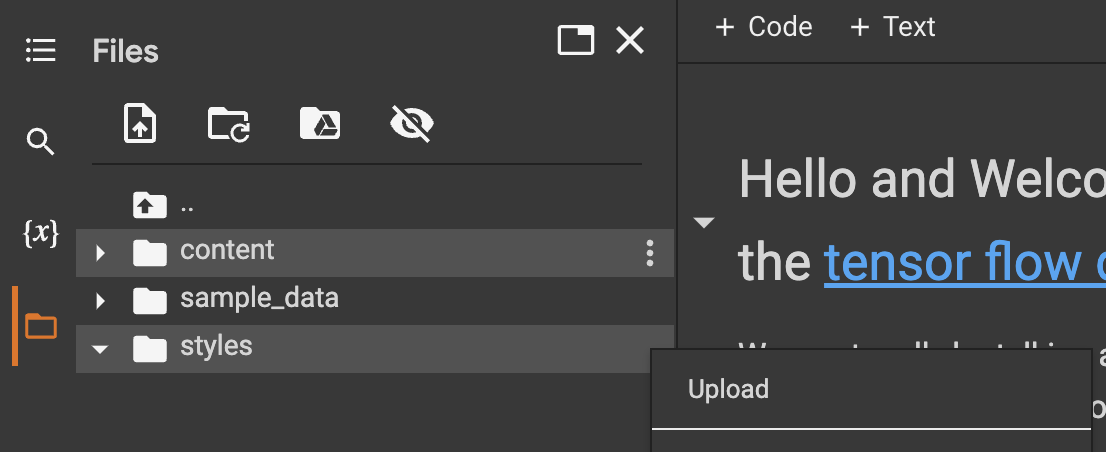

If you dont wanna do anything else but make pretty picture.
Then go up to runtime and click run all. Then scroll down to the bottom for the last bit of instructions. Give it some trust and see you new stylized image. Do it now before I get really boring and you forget. 

# A Breif history of Convolutional Neural Nets's

some other people before him 

LeNet by Yann LeCun -
(picture of LeNet stolen from [the orginal paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)) 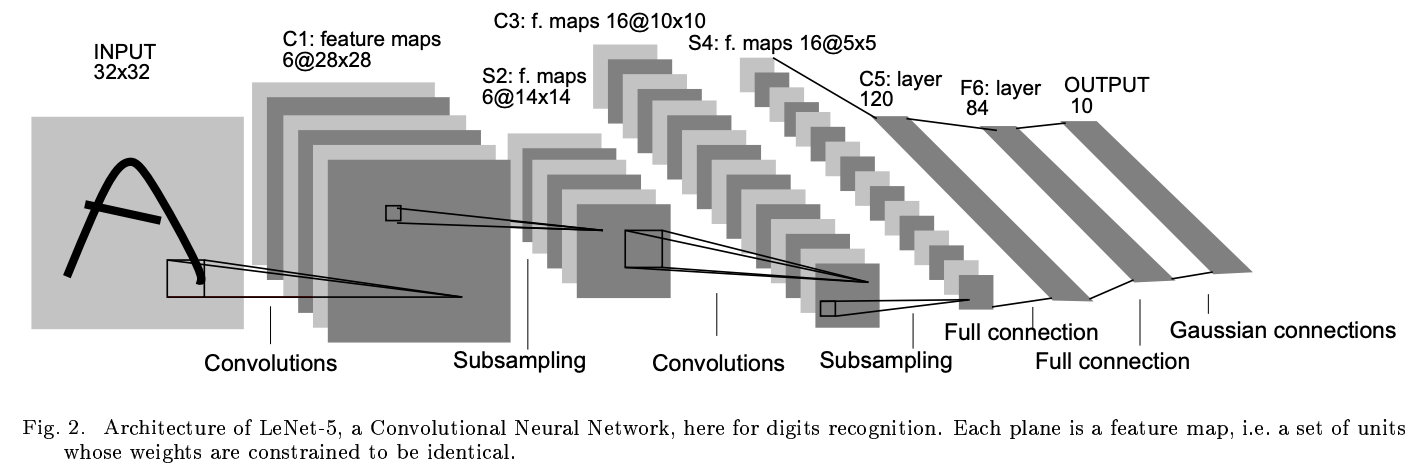
He really set the standards and architecture for them in the 90's thats still used today. Detecting low level features then higher level.

AlexNet - started utilizing gpu's

# Parts of a convolutional block.
 1) Convolution - filter an image for a particular feature (the weights and biases that get trained)\
 2) Non-linear activation function Relu - to detect the feature within the filtering \
3) Pooling - Condenses the image to enhance features \

[Kaggle Course on computer vision](https://www.kaggle.com/learn/computer-vision)

In [2]:
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time

In [3]:
# img pre-processing
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [4]:
# show one img
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

#show list images
def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

In [ ]:
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg',
  monet='https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2F1.bp.blogspot.com%2F_JNY6lW3tIEc%2FTOYkPkVzt2I%2FAAAAAAAAGck%2F_yQo7BvRcHg%2Fs1600%2FM-051.jpg&f=1&nofb=1'
)

styles_images = []
for k,v in style_urls.items():
  img = load_img(tf.keras.utils.get_file(fname=f'/content/styles/{k}.jpg', origin=v))
  styles_images.append([img,k])

for i in range(len(styles_images)//3):
  lists = styles_images[0+i*3:3+i*3]
  titles = []
  imgs = []
  for img, title in lists:
    titles.append(title)
    imgs.append(img)
  show_n(imgs, tuple(titles))

In [6]:
content_path = tf.keras.utils.get_file('/content/content/YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

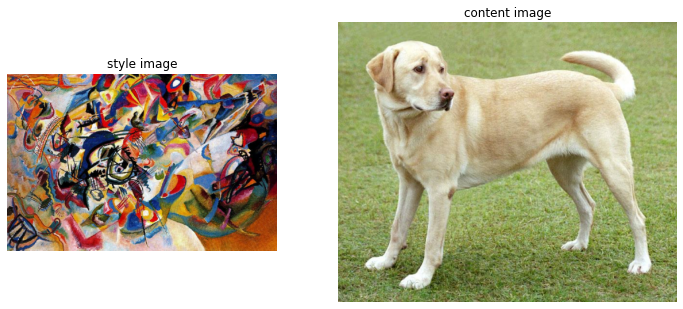

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

show_n([style_image,content_image], ('style image', 'content image'))

# VGG19 
The VGG19 model which is a large pre-trained convolution image classification network. Wow right. 

So what is a pre-trained model? - So some really smart people got together in a room and did all the hard + exspencive work for us. The model was orginally trained on the ImageNet dataset which has over 1.4 million images in total. It was trained to differentiate 1000 different class classifications - lots of different dogs cats and other animals why pawsome pics work well.

How it works is the neurel network learned some filters which captures features while training. It also learns what pictures it should apply which filters too. So it doesn't use all of the filters. These learned features are often transferable to different data. This trained model will contain learned features like edges or horizontal lines that you would be transferable to other images. 


It has 19 layers of convolutions hence at around 625MB. This is Video memeory so a bit more expensive.

Of the filters it thinks it should you we take a sort of average (GRAM) of them to attempt to understand the 'style' of the images.

# Using VGG19 for prediction

In [8]:
'''
vgg19 with classification head
its orginially trained to do object detection
'''
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
# include top head for prediction but not needed for style transfer
vgg_classify = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg_classify(x)
prediction_probabilities.shape
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(),5)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317136),
 ('golden_retriever', 0.23665282),
 ('kuvasz', 0.036357533),
 ('Chesapeake_Bay_retriever', 0.024182757),
 ('Greater_Swiss_Mountain_dog', 0.01864606)]

In [ ]:
tf.keras.utils.plot_model(vgg_classify, show_shapes=True)

All 1000 different classes the model was trained to predict. 

In [ ]:
all_labels = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(),1000)[0]
sorted([(class_name) for (number, class_name, prob) in all_labels])

In [11]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [12]:
# vgg with head
# vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

#itermediate layers for style and content

#matrix represent the content image feature map
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#build the model 
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model


style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255) 

(1, 21, 32, 512)
(1, 336, 512, 64)


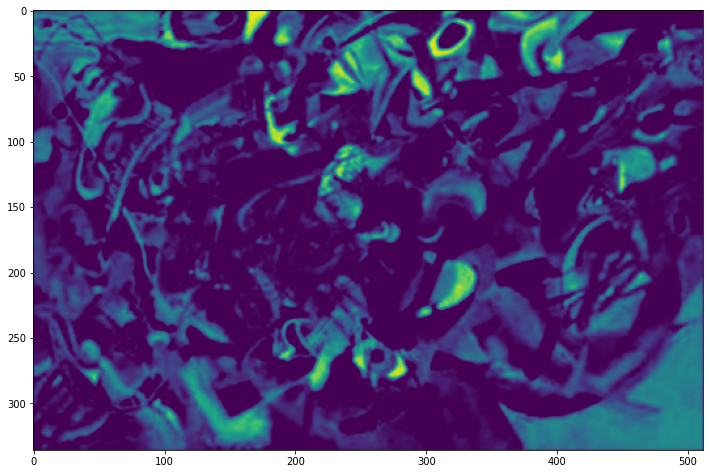

In [13]:
print(style_outputs[4].shape) #TensorShape([1, 336, 512, 64]) - 64 336x512 pixel featre maps
print(style_outputs[0].shape) # (1, 21, 32, 512)
imshow(style_outputs[0][0,:,:,5]) #Feature map the img passed thorugh the filter 

# feature_maps = []
# for i in range(64):
#   feature_maps.append(style_outputs[0][0,:,:,i])
# style_outputs[0][0,:,:,5]
# successive_feature_maps = style_outputs
# layer_names = style_layers

# for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#   if len(feature_map.shape)==4:
#     n_features = feature_map.shape[-1]
#     size = feature_map.shape[1]
#     display_grid = np.zeros((336, 512*n_features))
    
#     for i in range(n_features):
#       x = feature_map[0, :, :, i]
#       # x = x -x.mean()
#       # x = x/x.std()
#       # x = x*64 + 128
#       x = np.clip(x, 0, 255).astype('uint8')
#       display_grid[:, i*size : (i+1)*size] = x

#     scale = 20. / n_features 
#     plt.figure(figsize=(scale*n_features, scale))
#     plt.grid(False)
#     plt.title(layer_name)
#     plt.imshow(display_grid)

In [14]:
'''
The content of an image is represented by the values of the intermediate feature maps.
It turns out, the style of an image can be described by the means and correlations across the different feature maps
we use gram to get style of each layer

Finds which features activate together
'''
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #why b for layer?
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) #I*J 
  #where I is the length of F's first dim and J is legth of second dim
  return result/(num_locations)

In [15]:
#model that returns the style and content tensors
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [16]:
def style_transfer(content_image, style_image, epochs=4, steps_per_epoch=100, 
                   style_weight=1e-2, content_weight=1e4, debug=False):
  style_extractor = vgg_layers(style_layers)
  style_outputs = style_extractor(style_image*255) 
  extractor = StyleContentModel(style_layers, content_layers)
  
  #gradient descent
  #now that we have the styles and content extracted 
  #we can calc a mse for the images output relative to each target
  #then take the weighted sum of these losses
  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']
  # plt.imshow(content_targets['block5_conv2'], interpolation='nearest')
  # print(content_targets['block5_conv2'])

  image = tf.Variable(content_image)

  #clip pixel values values between 0 and 1
  def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

  # The ADAM
  opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

  # neat custom loss function 
  def style_content_loss(outputs):
      style_outputs = outputs['style']
      content_outputs = outputs['content']
      #mse
      style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                            for name in style_outputs.keys()])
      # avg over all style layers
      style_loss *= style_weight / num_style_layers

      #mse 
      content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                              for name in content_outputs.keys()])
      content_loss *= content_weight / num_content_layers
      loss = style_loss + content_loss
      return loss

  #add regularization term on the high freq components of the image. 
  #total variation loss
  def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

  def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

  total_variation_weight=30

  # new loss with total_variation_weight
  # this is the magic that we can talk about if you want
  @tf.function()
  def train_step(image):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)
      loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

  image = tf.Variable(content_image)
  start = time.time()


  step = 0
  if debug:
    display(tensor_to_image(image))

  # the training loop
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
      if debug:
        print(".", end='')
    if debug:
      #clear_output(wait=True)
      display(tensor_to_image(image))
      print("Train step: {}".format(step))

  if debug:
    end = time.time()
    print("Total time: {:.1f}".format(end-start))
  return image

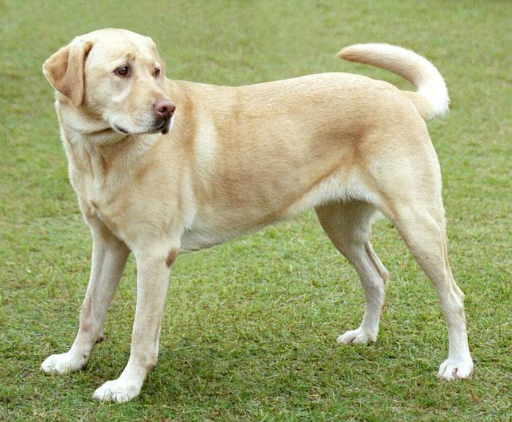

....................................................................................................

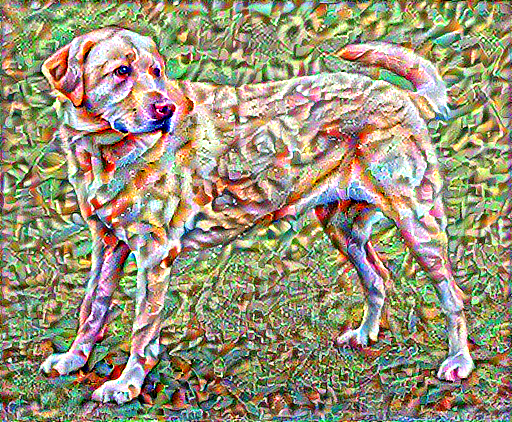

Train step: 100
....................................................................................................

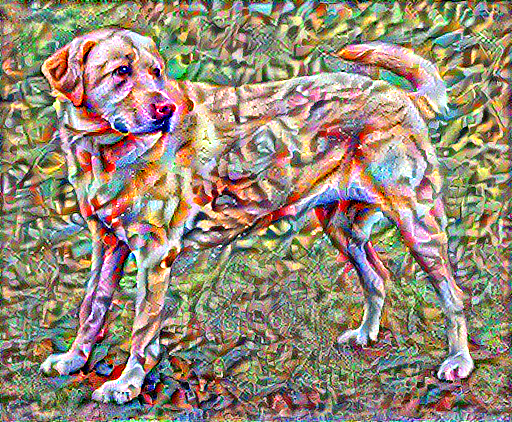

Train step: 200
....................................................................................................

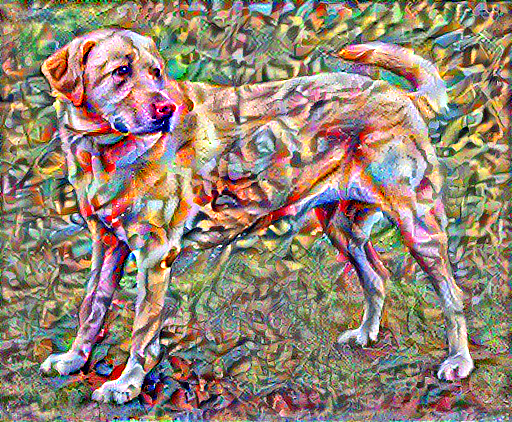

Train step: 300
....................................................................................................

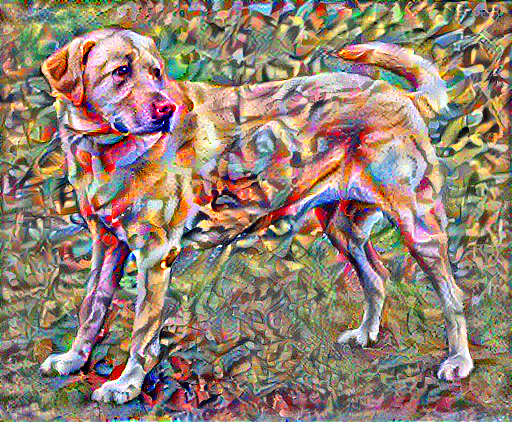

Train step: 400
Total time: 34.9


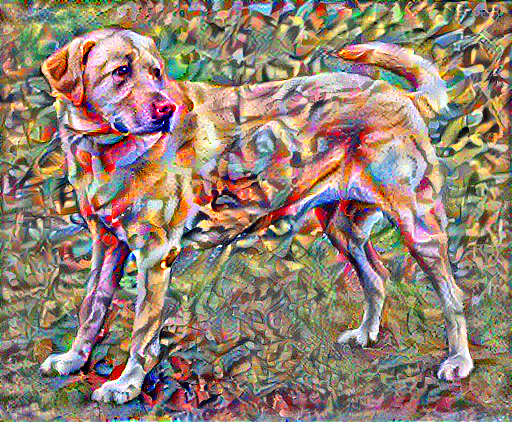

In [17]:
styled_img = style_transfer(content_image, style_image, epochs=4, steps_per_epoch=100, debug=True)
display(tensor_to_image(styled_img))

Closing notes that these are used today \
[Used to style transfer gta to look real for self driving](https://www.youtube.com/watch?v=22Sojtv4gbg) \
[DALL-E](https://huggingface.co/spaces/dalle-mini/dalle-mini) which uses a different a VQGAN different architecture but most almost certainly uses convilutions.

# Have fun styling your own picture be sure to send any cool ones to the channel

In [ ]:
prev_button = widgets.Button(description="Preview!")
style_button = widgets.Button(description="Style!")
output = widgets.Output()

def prev_click(b):
  # Display the message within the output widget.
  content_image = load_img('./content/'+content_dropdown.value)
  style_image = load_img('./styles/'+style_dropdown.value)
  with output:
    clear_output()
    show_n([style_image,content_image])


def style_click(b):
  content_image = load_img('/content/content/'+content_dropdown.value)
  style_image = load_img('/content/styles/'+style_dropdown.value)
  out_img = style_transfer(content_image, 
                           style_image,
                           epochs=epoch_slider.value, 
                           steps_per_epoch=step_slider.value, 
                           debug=True)
  with output:
    clear_output()
    show_n([style_image,content_image])
    imshow(out_img)



prev_button.on_click(prev_click)
style_button.on_click(style_click)


# style_weight=1e-2, content_weight=1e4,
# content_slider = widgets.IntSlider(value=1e4, max=1e5, description='content weight')
# style_slider = widgets.IntSlider(value=1e-2, max=5e-2, description='style weight')

epoch_slider = widgets.IntSlider(value=2, max=10, description='Epochs')
step_slider = widgets.IntSlider(value=100, max=200, description='Steps per epoch')
display(epoch_slider, step_slider)

style_img_files = [filename for filename in os.listdir('./styles') if ('.png' in filename or '.jpg' in filename)]
content_img_files = [filename for filename in os.listdir('./content') if ('.png' in filename or '.jpg' in filename)]
style_dropdown = widgets.Dropdown(options=style_img_files, description='Style')
content_dropdown = widgets.Dropdown(options=content_img_files, description='Content')
display(content_dropdown, style_dropdown)

display(prev_button, output)

display(style_button)


In [19]:
file_name = f'{content_dropdown.value.split(".")[0]}-{style_dropdown.value.split(".")[0]}-t:{epoch_slider.value*step_slider.value}-sw:{0}-cw:{0}.jpg'
tensor_to_image(styled_img).save(f'/content/output/{file_name}')